In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

# Loading The Gold Prices Dataset

In [115]:
df = pd.read_csv("/content/goldstock (1).csv")

# Dataset Overview

In [116]:
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Date        2511 non-null   object 
 2   Close       2511 non-null   float64
 3   Volume      2511 non-null   float64
 4   Open        2511 non-null   float64
 5   High        2511 non-null   float64
 6   Low         2511 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.4+ KB


In [118]:
df.describe()

,Unnamed: 0,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1260.792911,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,729.262879,298.824811,97600.769382,299.118187,301.262244,296.417703
min,0.000000,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,630.500000,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1259.000000,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1888.500000,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2532.000000,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


# Data Preparation

In [119]:
df = df.drop("Unnamed: 0", axis = 1)
df

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
...,...,...,...,...,...,...
2506,2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0
2507,2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2508,2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2509,2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8


In [120]:
df.drop(['Volume'], axis=1, inplace=True)
df

,Date,Close,Open,High,Low
0,2024-01-19,2029.3,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,2033.2,2067.3,2033.1
...,...,...,...,...,...
2506,2014-01-28,1250.5,1254.9,1261.9,1248.0
2507,2014-01-27,1263.5,1269.9,1280.1,1252.0
2508,2014-01-24,1264.5,1264.3,1273.2,1256.9
2509,2014-01-23,1262.5,1235.1,1267.1,1230.8


In [121]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [122]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2511 non-null   datetime64[ns]
 1   Close   2511 non-null   float64       
 2   Open    2511 non-null   float64       
 3   High    2511 non-null   float64       
 4   Low     2511 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 98.2 KB


In [124]:
df.head()

,Date,Close,Open,High,Low
0,2014-01-22,1238.6,1240.5,1243.5,1235.5
1,2014-01-23,1262.5,1235.1,1267.1,1230.8
2,2014-01-24,1264.5,1264.3,1273.2,1256.9
3,2014-01-27,1263.5,1269.9,1280.1,1252.0
4,2014-01-28,1250.5,1254.9,1261.9,1248.0


In [125]:
df.isnull().sum()

Date     0
Close    0
Open     0
High     0
Low      0
dtype: int64

In [126]:
df.duplicated().sum()

18

# Visualizing Gold Price History Data

In [127]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'})

In [128]:
#Extract features from Date column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Day'] = df.index.day

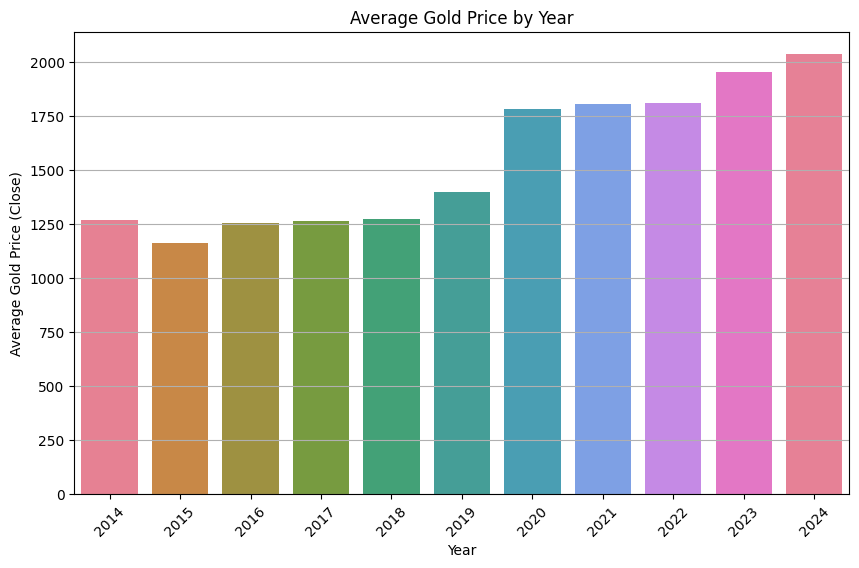

In [129]:
# Prepare data for plotting
avg_price_by_year = df.groupby('Year')['Close'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Close', hue='Year', data=avg_price_by_year, palette="husl", dodge=False, legend=False)
plt.title('Average Gold Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Gold Price (Close)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Splitting The Data

##### We will consider last year's prices for testing

In [53]:
testSize = df[df.Date.dt.year==2023].shape[0]
testSize

250

#### Plotting Training And Testing Sets

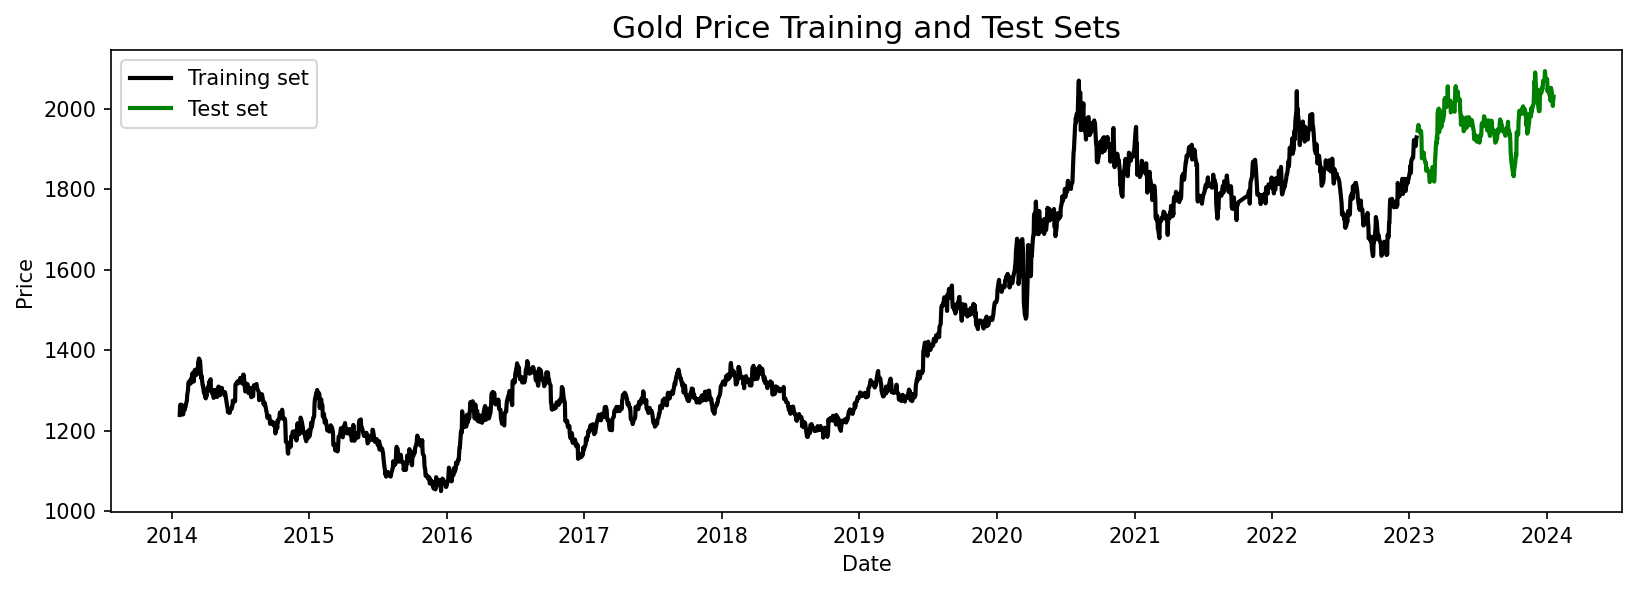

In [54]:
plt.figure(figsize=(13, 4), dpi=150)
plt.plot(df.Date[:-testSize], df.Close[:-testSize], color='black', lw=2)
plt.plot(df.Date[-testSize:], df.Close[-testSize:], color='green', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 10})
plt.show()

In [55]:
scaler = MinMaxScaler()

In [56]:
windowSize = 60

##### Training Set

In [57]:
train_data = df.Close[:-testSize]
train_data = scaler.fit_transform(train_data.values.reshape(-1,1))

In [58]:
X_train = []
y_train = []

for i in range(windowSize, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

##### Testing Set

In [59]:
test_data = df.Close[-testSize-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [60]:
X_test = []
y_test = []

for i in range(windowSize, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [61]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [62]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [63]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2201, 60, 1)
y_train Shape:  (2201, 1)
X_test Shape:   (250, 60, 1)
y_test Shape:   (250, 1)


# Building LSTM Network

In [64]:
def define_model():
    input1 = Input(shape=(windowSize,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [77]:
model = define_model()
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_split=0.1, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 64)            16896     
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_7 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

# Evaluating The Model

In [78]:
y_pred = model.predict(X_test)

8/8 [==============================] - 2s 31ms/step


In [79]:
MAPE = mean_absolute_percentage_error(y_pred, y_test)

In [80]:
print("MAPE: ", MAPE)
print("Accuracy: ", 1 - MAPE)

MAPE:  0.031431140511841434
Accuracy:  0.9685688594881585


# Visualizing Results

In [81]:
y_test_true= scaler.inverse_transform(y_test)
y_pred_true = scaler.inverse_transform(y_pred)

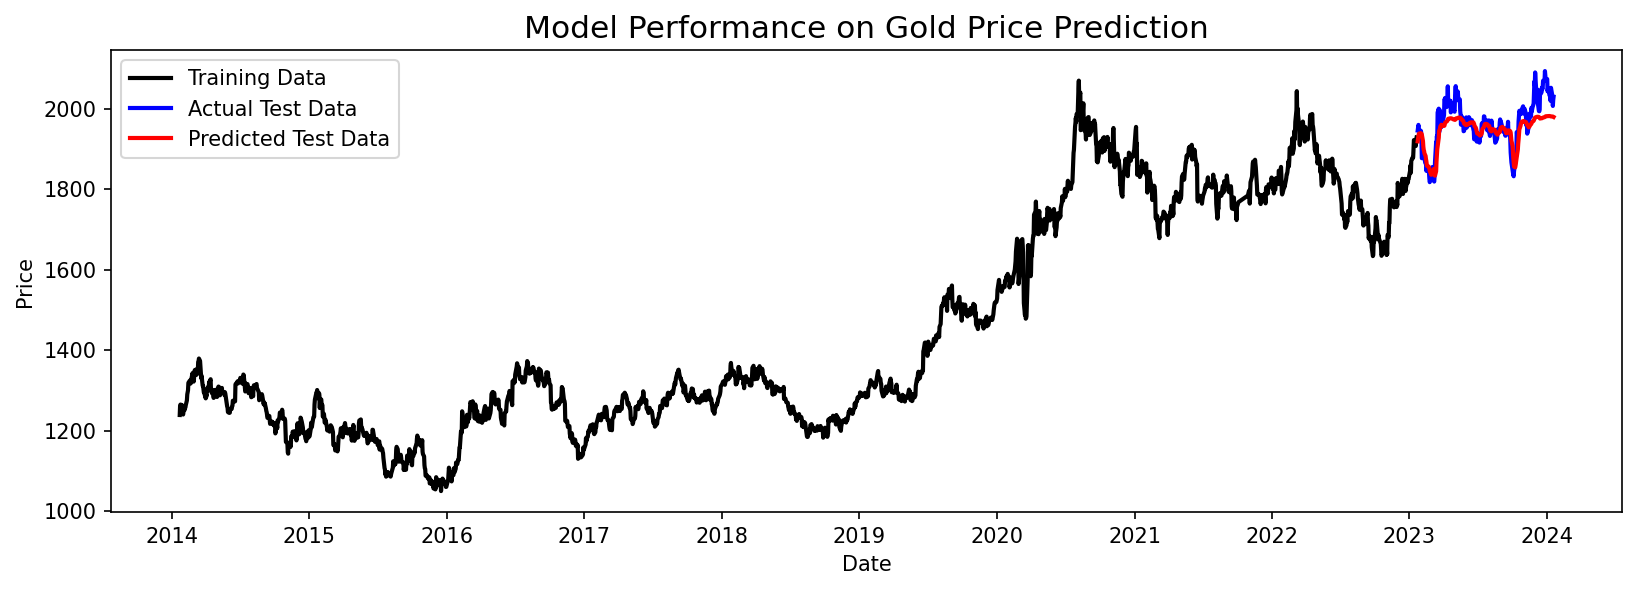

In [82]:
plt.figure(figsize=(13, 4), dpi=150)
plt.plot(df['Date'].iloc[:-testSize], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-testSize:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-testSize:], y_pred_true, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 10})
plt.show()